# Master Drifter Evaluation Notebook

***

In [136]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.io import loadmat
from sys import float_info as floats
from salishsea_tools import viz_tools

%matplotlib inline

In [158]:
plt.rcParams['font.size'] = 14

***

### Skill score definition

[Liu and Weisberg 2011, JGR Oceans](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010JC006837)

$$\left. s = \sum_{i=1}^Nd_i \middle/ \sum_{i=1}^NI_{oi} \right.$$

In [34]:
def mtime2datetime(mtime):
    """Convert matlab time to python datetime object
    """
    
    pytime = datetime.fromordinal(int(mtime) - 366) + timedelta(days=mtime%1)
    
    return pytime

In [105]:
# Paths, files and definitions
paths = {
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'drifters': '/ocean/shared/drifters/data/L3/Salish_L3_20190728T103529.mat',
    'out': '/data/bmoorema/results/parcels/drifters_base/',
}
grid = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
drifters = loadmat(paths['drifters'])['drift'][0]
IDs = [4, 32, 73, 82, 94, 106, 132, 142]
deg2m = 111000 * np.cos(50 * np.pi / 180)
duration = timedelta(days=5)

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/bmoorema/anaconda3/lib/python3.7/si

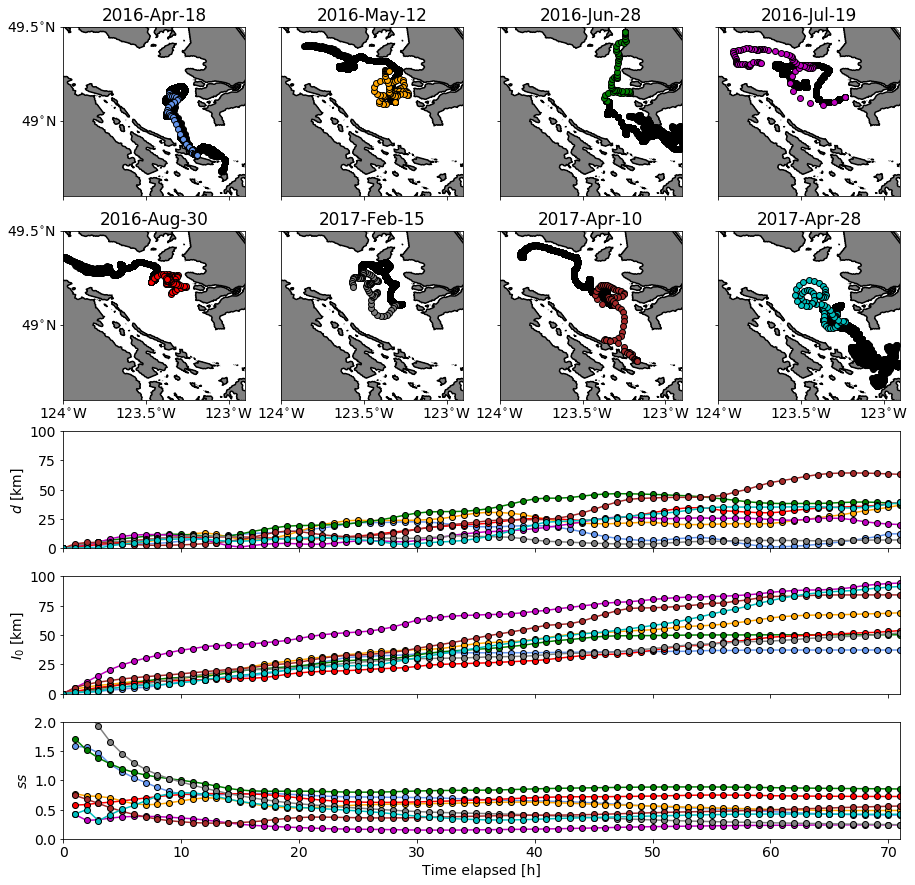

In [159]:
# Make figure
fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(5, 4, height_ratios=[3, 3, 2, 2, 2])
axs_maps = [fig.add_subplot(gs[row, col]) for row in range(2) for col in range(4)]
axs_metrics = [fig.add_subplot(gs[row+2, :]) for row in range(3)]
ylims, ylabels = [(0, 100), (0, 100), (0, 2)], ['$d$ [km]', '$I_0$ [km]', '$ss$']
axs_metrics[2].set_xlabel('Time elapsed [h]')
for ax, ylim, ylabel in zip(axs_metrics, ylims, ylabels):
    ax.set_xlim([0, 71])
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    if ylabel != '$ss$': ax.xaxis.set_ticklabels('')

# Loop through simulations
for ax, ID, color in zip(axs_maps, IDs, ['cornflowerblue', 'orange', 'g', 'm', 'r', 'gray', 'brown', 'c']):
    
    # Parse ID
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    t_obs = np.array([mtime2datetime(float(t)) for t in drifters['mtime'][dindex]])
    fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [t_obs[0], t_obs[0]+duration]) + '.nc'
    metrics = {'dl': np.empty(0), 'd': np.empty((0, 50))}
    label = t_obs[0].strftime('%Y-%b-%d')
    
    # Make map area
    ax.contourf(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
    ax.contour(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([-124, -122.9])
    ax.set_ylim([48.6, 49.5])
    ax.set_title(label)
    ax.xaxis.set_ticks([-124, -123.5, -123])
    ax.yaxis.set_ticks([49, 49.5])
    ax.xaxis.set_ticklabels(['124$^{\circ}$W', '123.5$^{\circ}$W', '123$^{\circ}$W'])
    ax.yaxis.set_ticklabels(['49$^{\circ}$N', '49.5$^{\circ}$N'])
    viz_tools.set_aspect(ax)
    if (ID != 4) and (ID != 94): ax.yaxis.set_ticklabels('')
    if ID < 94: ax.xaxis.set_ticklabels('')

    # Load simulation
    with xr.open_dataset(paths['out'] + fn) as data:

        # Load and plot trajectories
        times = data.time[0, :].values.astype('datetime64[s]').astype(datetime)
        lons, lats = data.lon.values, data.lat.values
        
        # Loop through simulation time points
        index = 0
        for time, lon, lat in zip(times[:72], lons.T, lats.T):
            
            # Extract observations
            ilast = index
            index = abs(t_obs - time).argmin()
            lon_obs, lat_obs = drifters['lon'][dindex], drifters['lat'][dindex]
            ax.plot(lon, lat, 'ko', zorder=1)
            ax.plot(lon_obs[index], lat_obs[index], 'ko', markerfacecolor=color, zorder=2)

            # Calculate metrics
            d = np.sqrt((lon - lon_obs[index])**2 + (lat - lat_obs[index])**2) * deg2m * 1e-3
            dl = np.sqrt((lon_obs[index] - lon_obs[ilast])**2 + (lat_obs[index] - lat_obs[ilast])**2) * deg2m * 1e-3
            metrics['dl'] = np.append(metrics['dl'], dl)
            metrics['d'] = np.concatenate((metrics['d'], d[np.newaxis, :]))

    # Calc skill score
    I_0 = np.cumsum(metrics['dl'])[:, np.newaxis]
    ss = np.cumsum(metrics['d'], axis=0) / np.cumsum(I_0, axis=0)
    
    for ax, var in zip(axs_metrics, [metrics['d'], I_0, ss]):
        ax.plot(var.mean(axis=1), 'o-', color=color, markeredgecolor='k')
        
fig.savefig('/home/bmoorema/Desktop/skill_scores.png', bbox_inches='tight')